In [ ]:
import pandas as pd
import random

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("job_data_files/seniority_labelled_development_set.csv")
df_test = pd.read_csv("job_data_files/seniority_labelled_test_set.csv")

print(df.columns)

Index(['job_id', 'job_title', 'job_summary', 'job_ad_details',
       'classification_name', 'subclassification_name', 'y_true'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   job_id                  2752 non-null   int64 
 1   job_title               2752 non-null   object
 2   job_summary             2752 non-null   object
 3   job_ad_details          2752 non-null   object
 4   classification_name     2752 non-null   object
 5   subclassification_name  2752 non-null   object
 6   y_true                  2752 non-null   object
dtypes: int64(1), object(6)
memory usage: 150.6+ KB
None


In [13]:
# Missing values
print(df.isnull().sum())

job_id                     0
job_title                  0
job_summary                0
job_ad_details             0
classification_name        0
subclassification_name     0
y_true                     0
job_summary_language       0
job_ad_details_language    0
y_true_merged              0
values_count               0
text                       0
dtype: int64


In [3]:
for col in df.columns:
    print(f"Unique values in {col}: {df[col].nunique()}")

Unique values in job_id: 2752
Unique values in job_title: 2751
Unique values in job_summary: 2747
Unique values in job_ad_details: 2752
Unique values in classification_name: 30
Unique values in subclassification_name: 296
Unique values in y_true: 64


In [4]:
# For each column, find any duplicates and print the rows
for col in df.columns:
    if df[col].duplicated().any():
        print(f"{df[col].duplicated().sum()} Duplicates found in {col}:")
        print(df[df[col].duplicated(keep=False)])
        print()
    else:
        print(f"No duplicates in {col}\n")

No duplicates in job_id

1 Duplicates found in job_title:
       job_id      job_title  \
60   40805623  Administrator   
159  37957378  Administrator   

                                           job_summary  \
60   We are looking for a highly motivated administ...   
159  First point of contact for the Village and is ...   

                                        job_ad_details    classification_name  \
60   <HTML><p><strong>International Office</strong>...   Government & Defence   
159  <HTML><p><strong>About CLV</strong><br/><br/>R...  Hospitality & Tourism   

            subclassification_name        y_true  
60                      Government  intermediate  
159  Front Office & Guest Services  intermediate  

5 Duplicates found in job_summary:
        job_id                                          job_title  \
46    32402173  English / Humanities / Physical Education Teac...   
680   32078906                  Food Technology Teacher - 1061979   
958   30011295            Enro

In [5]:
# Detect language in job_summary and job_ad_details columns
DetectorFactory.seed = 0


def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None


# Apply the language detection function to the job_summary and job_ad_details columns
df["job_summary_language"] = df["job_summary"].apply(detect_language)
df["job_ad_details_language"] = df["job_ad_details"].apply(detect_language)

# Check the detected languages
print("Detected languages in job_summary:")
print(df["job_summary_language"].value_counts())
print()
print("Detected languages in job_ad_details:")
print(df["job_ad_details_language"].value_counts())

Detected languages in job_summary:
en    2693
de      13
it       9
fr       8
da       6
nl       5
ca       4
ro       3
af       2
cy       2
es       2
tl       2
id       1
sv       1
pt       1
Name: job_summary_language, dtype: int64

Detected languages in job_ad_details:
en    2751
no       1
Name: job_ad_details_language, dtype: int64


In [6]:
# Job summary with es as language
print("Job summary with es as language:")
print(df[df["job_summary_language"] == "it"]["job_summary"].head(10).tolist())

Job summary with es as language:
['Full time MRI Radiographer (MRI MRT) role', 'Casual Cello Tutor', 'Crane Operators ', 'Part-time or Fulltime', 'Permanent Full-time position.Be part of a digital & cultural transformation.', 'Regional Agronomist ', 'Permanent Full Time opportunity. ', 'Supportive team environment | Full time administration position!', 'Trade Qualified Glazier']


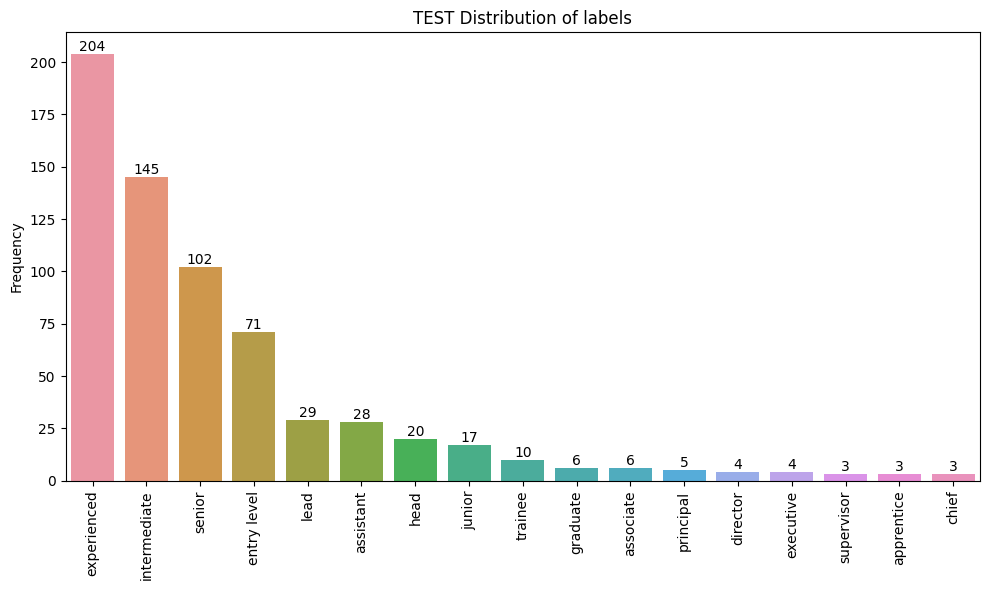

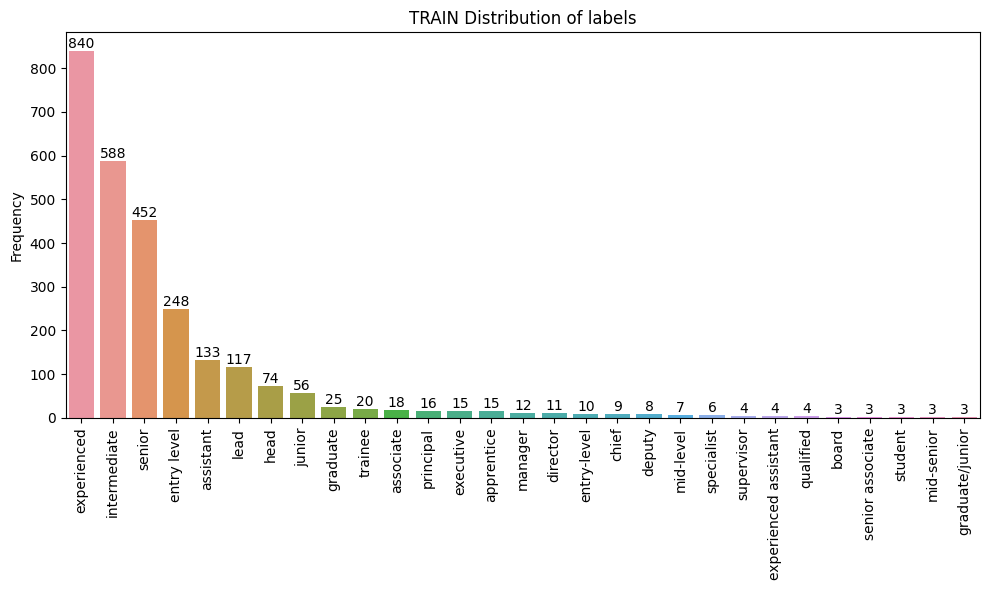

Missing values in each column:
Series([], dtype: int64)


In [7]:
# TEST label distributions
value_counts_test = df_test["y_true"].value_counts()
repeated_values_test = value_counts_test[value_counts_test >= 3].sort_values(
    ascending=False
)

# Plot the distribution of repeated values
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=repeated_values_test.index, y=repeated_values_test.values)
plt.title(f"TEST Distribution of labels")
plt.xticks(rotation=90)
plt.ylabel("Frequency")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge")

plt.tight_layout()
plt.show()

# DEVELOPMENT label distributions
value_counts = df["y_true"].value_counts()
repeated_values = value_counts[value_counts >= 3].sort_values(ascending=False)

# Plot the distribution of repeated values
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=repeated_values.index, y=repeated_values.values)
plt.title(f"TRAIN Distribution of labels")
plt.xticks(rotation=90)
plt.ylabel("Frequency")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge")

plt.tight_layout()
plt.show()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

In [8]:
# Merge columns that mean the same
# 1. entry-level -> entry level
# 2. mid-senior and mid-level -> intermidiate
# 3. board -> director

df["y_true_merged"] = df["y_true"].replace(
    {
        "entry-level": "entry level",
        "mid-senior": "intermediate",
        "mid-level": "intermediate",
        "board": "director",
    }
)

# Values with less than 8 occurrences are not considered
df["values_count"] = df["y_true_merged"].map(df["y_true_merged"].value_counts())

# Merge all text inputs into one column
df["text"] = (
    df["job_title"].astype(str)
    + " "
    + df["job_summary"].astype(str)
    + " "
    + df["job_ad_details"].astype(str)
)

In [ ]:
df_train = df[df["y_true_merged"].value_counts() >= 8]
df_train = df_train[["text", "y_true_merged"]]

In [10]:
def baseline_predict_label(text: str, labels: list) -> str:
    """
    Predict the label of a job based on the presence of specific keywords.
    """

    text = text.lower().replace("-", " ")

    for label in labels:
        if label in text:
            return label

    # If no label is found, return the most common label
    return "experienced"

In [11]:
# Get baseline accuracy score
train_labels = df_train["y_true_merged"].unique()
print(f"Labels: {train_labels}")
df_train["y_pred"] = df_train["text"].apply(
    lambda x: baseline_predict_label(x, train_labels)
)

from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(df_train["y_true_merged"], df_train["y_pred"])
print(f"Random baseline accuracy: {1/len(train_labels):.2f}")
print(f"Dummy Baseline accuracy: {accuracy:.2f}")


Labels: ['intermediate' 'senior' 'lead' 'head' 'experienced' 'entry level'
 'executive' 'assistant' 'deputy' 'director' 'trainee' 'associate'
 'graduate' 'junior' 'chief' 'principal' 'apprentice' 'manager']
Random baseline accuracy: 0.06
Dummy Baseline accuracy: 0.32


In [12]:
df_test["text"] = (
    df_test["job_title"].astype(str)
    + " "
    + df_test["job_summary"].astype(str)
    + " "
    + df_test["job_ad_details"].astype(str)
)
df_test["y_pred"] = df_test["text"].apply(
    lambda x: baseline_predict_label(x, train_labels)
)

# Calculate the accuracy score
accuracy_test = accuracy_score(df_test["y_true"], df_test["y_pred"])
print(f"Random baseline accuracy: {1/len(train_labels):.2f}")
print(f"Dummy Baseline accuracy: {accuracy_test:.2f}")

Random baseline accuracy: 0.06
Dummy Baseline accuracy: 0.30
